# Recruitment Prediction

We first import the relevant libraries, import the data and check if everything looks correct.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('arend.mplstyle') # Stylesheet for plot. Nice formatting for Papers


In [2]:

df = pd.read_csv("Vacancies.csv", sep = ",", encoding = "ANSI")

target = "Average monthly salary in the municipalities"
df.head(20)

,region,observations,quarter,"Recruitment and vacancy rate, Business sector (KV)"
0,SE Sweden,Recruitment,2015K2,2.1
1,SE Sweden,Recruitment,2015K3,1.8
2,SE Sweden,Recruitment,2015K4,1.9
3,SE Sweden,Recruitment,2016K1,2.4
4,SE Sweden,Recruitment,2016K2,2.4
5,SE Sweden,Recruitment,2016K3,2.0
6,SE Sweden,Recruitment,2016K4,2.1
7,SE Sweden,Recruitment,2017K1,2.7
8,SE Sweden,Recruitment,2017K2,2.6
9,SE Sweden,Recruitment,2017K3,2.3


We are only intrested in the recruitment rate so we drop the Observations for Vacancy rate 

In [4]:
df = df.loc[df.observations == "Recruitment"]
df = df.drop("observations", axis = 1)
df.head()


,region,quarter,"Recruitment and vacancy rate, Business sector (KV)"
0,SE Sweden,2015K2,2.1
1,SE Sweden,2015K3,1.8
2,SE Sweden,2015K4,1.9
3,SE Sweden,2016K1,2.4
4,SE Sweden,2016K2,2.4


In [5]:
df.describe(include = 'all')

,region,quarter,"Recruitment and vacancy rate, Business sector (KV)"
count,243,243,243.000000
unique,9,27,NaN
top,SE Sweden,2015K2,NaN
freq,27,9,NaN
mean,NaN,NaN,2.166255
std,NaN,NaN,0.550894
min,NaN,NaN,1.100000
25%,NaN,NaN,1.800000
50%,NaN,NaN,2.100000
75%,NaN,NaN,2.600000


## Cleaning the data

We see that we don't have NA-Values. But we still have the question how we deal with the variable *quarter*

First we split the variable quarter into year and quarter, so
2015K2 -> Year = 2015, Quarter = 2



In [7]:
df_year = df.quarter.str.split("K", expand = True) # Split by the character "K"
df_year = df_year.rename({0: "year", 1: "quarter"}, axis = 1)
df = df.drop("quarter", axis = 1)
df = df.join(df_year)
df = df.apply(pd.to_numeric, errors='ignore') # Convert quarter column from string to numeric
df.head()

,region,"Recruitment and vacancy rate, Business sector (KV)",year,quarter
0,SE Sweden,2.1,2015,2
1,SE Sweden,1.8,2015,3
2,SE Sweden,1.9,2015,4
3,SE Sweden,2.4,2016,1
4,SE Sweden,2.4,2016,2


### Looking at the data
To decide which approach to use, we first plot the different quarters


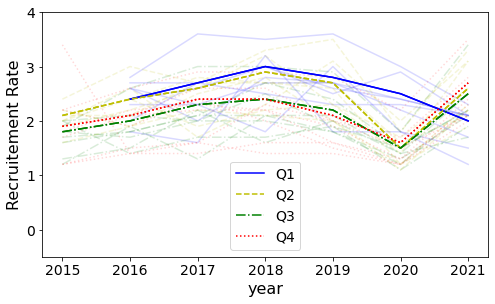

In [9]:
target = "Recruitment and vacancy rate, Business sector (KV)"
df_sweden = df.loc[df.region == "SE Sweden"]
golden = [8, 4.5]
fig, ax = plt.subplots(figsize = golden)
colors = ["b", "y", "g", "r"]
line = ["-", "--", "-.", ":"]
for i in range(1, 5):
    df_sweden.loc[df_sweden.quarter == i].plot(x = "year", y = target, ax = ax, c = colors[i-1], linestyle = line[i-1])


for r in df.region.unique():
    for i in range(1, 5):
        df.loc[df.quarter == i].loc[df.region == r].plot(x = "year", y = target, ax = ax, c =colors[i-1], alpha = 0.15 , linestyle = line[i-1])

for i in range(1, 5):
    df_sweden.loc[df_sweden.quarter == i].plot(x = "year", y = target, ax = ax, c = colors[i-1], linestyle = line[i-1])

ax.legend(["Q1", "Q2", "Q3", "Q4"])
ax.set_ylim([-0.5,4])
ax.set_ylabel("Recruitement Rate")
fig.savefig("compareQuarters.pdf")

We can see that the data is all over the place, only thing we can see is that recruitement rates in  Q1 and Q2 are higher than Q3 and Q4

### Create time variable

We will now create a time variable that is `quarter-1 * (0.25) + year`. We can see if there is a general direction here.

In [10]:
df['time'] = (df.quarter - 1) * 0.25 + df.year
df.head()

,region,"Recruitment and vacancy rate, Business sector (KV)",year,quarter,time
0,SE Sweden,2.1,2015,2,2015.25
1,SE Sweden,1.8,2015,3,2015.50
2,SE Sweden,1.9,2015,4,2015.75
3,SE Sweden,2.4,2016,1,2016.00
4,SE Sweden,2.4,2016,2,2016.25


Text(0.5, 0, 'Year')

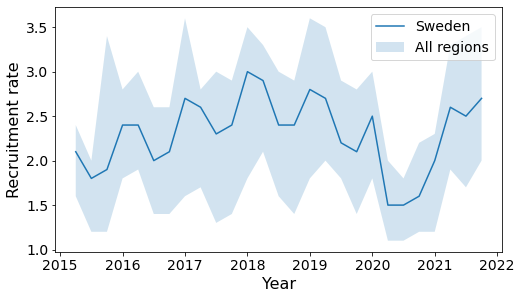

In [11]:
fig, ax =plt.subplots(figsize = golden)
#df.groupby(["time"])[target].mean().plot(x = "time", y = target, ax = ax)
df.loc[df.region =="SE Sweden"].plot(x = "time", y = target, ax = ax)
max_year = df.groupby(["time"])[target].min()
min_year = df.groupby(["time"])[target].max()
ax.fill_between(df.time.unique(), max_year, min_year, alpha = 0.2)
ax.legend(["Sweden", "All regions"])
ax.set_ylabel("Recruitment rate")
ax.set_xlabel("Year")


The plot seems to conclude that there is some sort of seasonality, but let's look at all 9 municipalities.

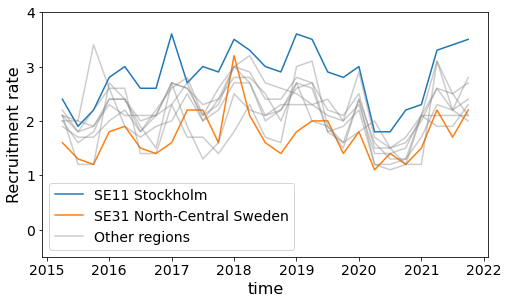

In [12]:
regions = df.region.unique()


fig, ax = plt.subplots(figsize = golden)

interesting_regions = ["SE11 Stockholm", "SE31 North-Central Sweden"]
for r in interesting_regions:
    df.loc[df.region == r].plot(x = "time", y = target, ax = ax)
for r in regions:
    if r in interesting_regions:
        #alpha = 1
        pass
    else:
        color = "grey"   
        alpha = 0.4
        df.loc[df.region == r].plot(x = "time", y = target, ax = ax, color = color, alpha = alpha)
ax.legend(interesting_regions + ["Other regions"])
ax.set_ylabel("Recruitment rate")
ax.set_ylim([-0.5,4])
fig.savefig("Recruitment_Time_comparision.pdf")

The data seems very jagged, a simple Linear regression will not perform well. We still want to see how it would compare to Decision Trees to give a general statement

### Fitting the model

1. Linear regression (Quarter + Year)
2. Decision Tree (Quarter + Year)
3. Linear Regression (time)
4. Decision Tree (time)


### Preparing data for Quarter + Year
1. Drop the "time" column
2. One-Hot encode region column with `pd.get_dummies`

In [14]:
X = df.drop([target,"time"], axis = 1)
y = df[[target]]
X_enc = pd.get_dummies(X, columns = ["region", "quarter"])
X_enc.head()

,year,region_SE Sweden,region_SE11 Stockholm,region_SE12 East-Central Sweden,region_SE21 Småland and islands,region_SE22 South Sweden,region_SE23 West Sweden,region_SE31 North-Central Sweden,region_SE32 Central Norrland,region_SE33 Upper Norrland,quarter_1,quarter_2,quarter_3,quarter_4
0,2015,1,0,0,0,0,0,0,0,0,0,1,0,0
1,2015,1,0,0,0,0,0,0,0,0,0,0,1,0
2,2015,1,0,0,0,0,0,0,0,0,0,0,0,1
3,2016,1,0,0,0,0,0,0,0,0,1,0,0,0
4,2016,1,0,0,0,0,0,0,0,0,0,1,0,0


In [17]:
y.head()

,"Recruitment and vacancy rate, Business sector (KV)"
0,2.1
1,1.8
2,1.9
3,2.4
4,2.4


In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

clf = LinearRegression()

scores = cross_val_score(clf, X_enc, y, cv = 5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-0.03 accuracy with a standard deviation of 0.23


In [16]:
from sklearn.tree import DecisionTreeRegressor

clf = DecisionTreeRegressor()
scores = cross_val_score(clf, X_enc, y, cv = 5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-0.15 accuracy with a standard deviation of 0.31


### Fitting on time axis instead of year + quarter

The last models performed quite badly, we can try the method of just fitting over the time, which has less features and might perform more accurately

In [17]:
X_time = df.drop([target, "year", "quarter"], axis = 1)
X_time = pd.get_dummies(X_time, ["region"])

clf = LinearRegression()

scores = cross_val_score(clf, X_time, y, cv = 5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

-0.18 accuracy with a standard deviation of 0.20


In [18]:
clf = DecisionTreeRegressor()

scores = cross_val_score(clf, X_time, y, cv = 5)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.01 accuracy with a standard deviation of 0.24


### Result

All models perform terrible, let's look at a model to see what happens

In [19]:
clf = LinearRegression()
X_future = X_time.copy()
X_future.time += 6.75
X_future.head()

,time,region_SE Sweden,region_SE11 Stockholm,region_SE12 East-Central Sweden,region_SE21 Småland and islands,region_SE22 South Sweden,region_SE23 West Sweden,region_SE31 North-Central Sweden,region_SE32 Central Norrland,region_SE33 Upper Norrland
0,2022.00,1,0,0,0,0,0,0,0,0
1,2022.25,1,0,0,0,0,0,0,0,0
2,2022.50,1,0,0,0,0,0,0,0,0
3,2022.75,1,0,0,0,0,0,0,0,0
4,2023.00,1,0,0,0,0,0,0,0,0


In [20]:
clf.fit(X_time, y)
y_future = clf.predict(X_future)

In [21]:
current = pd.concat([X, y], axis = 1)
future = X.copy()
future.year += 7
future[target] = y_future
future.head()

,region,year,quarter,"Recruitment and vacancy rate, Business sector (KV)"
0,SE Sweden,2022,2,2.276923
1,SE Sweden,2022,3,2.275275
2,SE Sweden,2022,4,2.273626
3,SE Sweden,2023,1,2.271978
4,SE Sweden,2023,2,2.270330


Text(0, 0.5, 'Recruitment Rate')

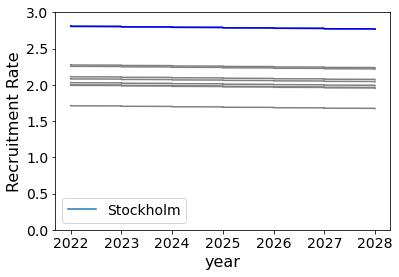

In [29]:
fig, ax = plt.subplots()
future.loc[future.region.str.contains("Stock")].plot(x = "year", y = target, ax = ax)
for r in future.region.unique():
    future.loc[future.region == r].plot(x = "year", y = target, ax = ax, c = "grey")
future.loc[future.region.str.contains("Stock")].plot(x = "year", y = target, ax = ax, c = "blue")
ax.legend(["Stockholm"])
ax.set_ylim([0,3])
ax.set_ylabel("Recruitment Rate")

The linear regression eats up all seasonality. No wonder it performs badly. At least we can see that Stockholm has a lot higher recruitment rate that every other place.